# Introduction


Le but de ce projet est de mettre en pratique ce que j'ai appris dans la section sur le traitement des données du programme Udacity. L'ensemble de données est l'archive des tweets de l'utilisateur de Twitter sous le nom de WeRateDogs.


**Détail de projet**

- Le traitement des données, qui consiste à :
    1. A partir de fichiers twitter-archive-enhanced.csv
    2. A partir de liens
    3. À partir de l'API Tweeter.
        . Évaluation des données
        . Nettoyage des données
- Stockage, analyse et visualisation des données
- produit un rapports     


**Sources de donnees**
 - twitter_archive_enhanced.csv
 - Image_predictions.tsv
 - L'URL suivante : ' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

***Nous Repondrons aux questions suivantes ?***

    - Q 1 Quelle est la race de chien la plus courant dans notre base de données
    - Q 2 : Quelle race de chien a obtenu la note moyenne la plus élevée
    - Q 3 Quels sont les noms de chien le plus populaire
    - Q 4 : Existe t il une correlation linéraire entre retweet et les favoris_tweet ?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import requests
import tweepy
import time
import re
import requests
import warnings
import datetime

from PIL import Image
from io import BytesIO

from IPython.display import Image
from functools import reduce


from jupyterthemes import jtplot
from tweepy import OAuthHandler

%matplotlib inline

***Twitter archive***

In [2]:
#load twitter achive file
twit_arch = pd.read_csv('C://Users//HEBRON//Desktop//UDACITY//Projet 2//twitter-archive-enhanced.csv')

twit_arch.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


***Image prediction***

In [3]:
#URL downloaded programatically & download image prediction file
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open('image-predictions.tsv', mode ='wb') as file:
    file.write(response.content)
    
imag_pred = pd.read_csv('C://Users//HEBRON//Desktop//UDACITY//Projet 2//image-predictions.tsv', sep = '\t')

In [4]:
imag_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


***Twitter API & Json***

In [5]:
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = twit_arch.tweet_id.values
len(tweet_ids)

2356

In [6]:
def tweet_extraction():
    count = 0
    fails_dict = {}
    start = timer()
    with open('tweet_json.txt', 'w') as outfile:
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
    end = timer()
    print(end - start)
    print(fails_dict)

https://stackoverflow.com/questions/47612822/how-to-create-pandas-dataframe-from-twitter-search-api

In [7]:
df_list = []

with open('C://Users//HEBRON//Desktop//UDACITY//Projet 2//tweet_json.txt') as file:
    for line in file:
        data = json.loads(line)
        keys = data.keys()
        user = data.get('user')
        id_str = data.get('id_str')
        retweet_count = data.get('retweet_count')
        favorite_count = data.get('favorite_count')
        df_list.append({'id_str': id_str,
                        'retweet_count': retweet_count,
                        'favorite_count': favorite_count})

In [8]:
tweet_count = pd.DataFrame(df_list, columns = ['id_str', 'retweet_count', 'favorite_count'])

In [9]:
tweet_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_str          2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


# Assessing the Data

Visual assessment

In [10]:
twit_arch.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [11]:
twit_arch.text.sample(30)

1692    This is Chuck. He's a neat dog. Very flexible....
798     You need to watch these two doggos argue throu...
1776    This is Izzy. She's showing off the dance move...
1043    RT @dog_rates: Extremely intelligent dog here....
229     This is Jerry. He's doing a distinguished tong...
1812    Say hello to Penny &amp; Gizmo. They are pract...
1229    This is Piper. She would really like that tenn...
1757    Meet Wilson. He got caught humping the futon. ...
767     RT @dog_rates: This is Arnie. He's a Nova Scot...
1100    *faints* 12/10 perfection in pupper form https...
1135    This is Wallace. He's a skater pup. He said se...
1758    This is Dash. He didn't think the water would ...
1267    This is Olaf. He's gotta be rare. Seems sturdy...
227     Meet Odin. He's supposed to be giving directio...
2267    Another topnotch dog. His name is Big Jumpy Ra...
1242    RT @twitter: @dog_rates Awesome Tweet! 12/10. ...
1346    Meet Lucia. She's a Cumulonimbus Floofmallow. ...
2198    This i

In [12]:
imag_pred

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [13]:
# This is an image for tweet_id 892420643555336193
Image(url = 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg')

In [14]:
print(imag_pred.p1_dog.value_counts())
print(imag_pred.p2_dog.value_counts())
print(imag_pred.p3_dog.value_counts())

True     1532
False     543
Name: p1_dog, dtype: int64
True     1553
False     522
Name: p2_dog, dtype: int64
True     1499
False     576
Name: p3_dog, dtype: int64


In [15]:
tweet_count

,id_str,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


***Programmatic assessment***

#### Archive

In [16]:
twit_arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [17]:
sum(twit_arch['tweet_id'].duplicated())

0

In [18]:
twit_arch.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [19]:
twit_arch.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [20]:
doggo = twit_arch.doggo.value_counts()
floofer = twit_arch.floofer.value_counts()
pupper = twit_arch.pupper.value_counts()
puppo = twit_arch.puppo.value_counts()

print(doggo); 
print(floofer); 
print(pupper); 
print(puppo)

None     2259
doggo      97
Name: doggo, dtype: int64
None       2346
floofer      10
Name: floofer, dtype: int64
None      2099
pupper     257
Name: pupper, dtype: int64
None     2326
puppo      30
Name: puppo, dtype: int64


In [21]:
twit_arch.name.value_counts().head(20)

None       745
a           55
Charlie     12
Lucy        11
Cooper      11
Oliver      11
Penny       10
Tucker      10
Lola        10
Winston      9
Bo           9
Sadie        8
the          8
Toby         7
Buddy        7
Bailey       7
an           7
Daisy        7
Milo         6
Jax          6
Name: name, dtype: int64

In [22]:
twit_arch.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

***Tweet_count***

In [23]:
tweet_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_str          2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


In [24]:
tweet_count.sample(10)

,id_str,retweet_count,favorite_count
576,800855607700029440,1889,0
671,789903600034189313,4858,11673
513,811627233043480576,3650,14265
1948,673688752737402881,534,1325
1719,680130881361686529,1078,2519
2315,666644823164719104,88,238
1546,689275259254616065,285,1273
1204,715758151270801409,1596,4085
130,867051520902168576,8425,33420
989,748699167502000129,1814,5213


***imag_pred***

In [25]:
imag_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [26]:
sum(imag_pred.jpg_url.duplicated())

66

Constats

### Qualité

***table twitter d'archives***

    - Valeurs manquantes dans les colonnes : in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp et extended_urls.
    - tweet_id est dtype int64 mais devrait être un objet
    - l'horodatage doit également être un type datetime64 dtype et separer en année, mois, jour
    - Informations manquantes pour les certainne race canins.
    - Supprimer les colonnes qui ne seront pas utilisées pour l'analyse
    - Corriger les numérateurs avec des décimales
    - Corriger les dénominateurs autres que 10
    - le nom de colonne floofer doit être orthographié 'floof'

***Tableau tweet_count***

    - La colonne "id_str" doit être remplacée par "tweet_id" afin de pouvoir fusionner les tables.


***Tableau imag_pred***

    - Les types de chiens dans les colonnes p1, p2 et p3 avaient des lettres majuscules et minuscules.
    - La colonne "tweet_id" doit être un objet dtype au lieu d'etre int64.
    - nous devons 66 jpg_url qui sont dupliqué
    - nous devons supprimes les colonnes qui ne sont pas nécessaire pour notre analyse
    - conservons la première prédiction vraie le long du niveau de confiance en tant que nouvelles colonnes.
    


### Propreté

    - Les tables "tweet_count" et "twitter archive" doivent être fusionnées.
    - La colonne source dans la table "twitter archive" semble désordonnée et encombre la table.
    - créer une nouvelle colonee nommé dog_breed pour (doggo, floof, pupper, puppo)

Les trois tables seront finalement fusionnées en une seule.

# Cleaning Data

In [27]:
twit_arch_clean = twit_arch.copy()
imag_pred_clean = imag_pred.copy()
tweet_count_clean = tweet_count.copy()

1. Twitter archive 

In [28]:
twit_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

***Supprimons de twit_arch_clean les colonnes retweeted_status_id et in_reply_to_status_id***

In [29]:
drop_retweet = twit_arch_clean[pd.notnull(twit_arch_clean['retweeted_status_id'])].index
drop_reply = twit_arch_clean[pd.notnull(twit_arch_clean['in_reply_to_status_id'])].index

twit_arch_clean.drop(index=drop_retweet, inplace=True)
twit_arch_clean.drop(index=drop_reply, inplace=True)

In [30]:
twit_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 

ref : https://pandas.pydata.org/docs/reference/api/pandas.notnull.html

    - Supprimons les colonnes avec des valeurs manquantes à l'aide de la méthode dropna(). 
    - Puis utilisons drop () pour supprimer la colonne source de la table

In [31]:
#supprimons les colonnes manquantes
twit_arch_clean.dropna(axis='columns',how='any', inplace=True)

#supprimons source
twit_arch_clean.drop(columns='source', inplace=True)

In [32]:
twit_arch_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None


    - Dans tweet_count_clean,  la colonne id_str doit être rempalcer par tweet_id à l'aide de la fonction rename().
    - Dans  archive_clean, le nom de colonne floofer doit être "floof". 
    - Les colonnes rating_numerator et rating_denominator doivent être renommer

**tweet_count_clean**

In [33]:
tweet_count_clean.rename(index=str, columns={"id_str": "tweet_id"}, inplace=True)

In [34]:
tweet_count_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 73.6+ KB


**twit_arch_clean**

In [35]:
twit_arch_clean.rename(columns={"floofer": "floof", 
                                         "rating_numerator": "rate_num",
                                         "rating_denominator": "rate_deno"}, inplace=True)


In [36]:
twit_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   2097 non-null   int64 
 1   timestamp  2097 non-null   object
 2   text       2097 non-null   object
 3   rate_num   2097 non-null   int64 
 4   rate_deno  2097 non-null   int64 
 5   name       2097 non-null   object
 6   doggo      2097 non-null   object
 7   floof      2097 non-null   object
 8   pupper     2097 non-null   object
 9   puppo      2097 non-null   object
dtypes: int64(3), object(7)
memory usage: 180.2+ KB


#### Fixing Datatypes

***twit_arch_clean***

ici, nous changeons le dtype de la colonne tweet_id de int64 a object en utilisant astype() function

In [37]:
twit_arch_clean['tweet_id'] = twit_arch_clean['tweet_id'].astype('str')

ici, l'horodatage doit également être un type datetime64 dtype et separer en année, mois, jour.

Ref : https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.year.html

In [38]:
#commencons par convertir timestamp en datetime
twit_arch_clean['timestamp'] = pd.to_datetime(twit_arch_clean['timestamp'])

#mettons sous la forme année, mois et jour
twit_arch_clean['year'] = twit_arch_clean['timestamp'].dt.year
twit_arch_clean['month'] = twit_arch_clean['timestamp'].dt.month
twit_arch_clean['day'] = twit_arch_clean['timestamp'].dt.day

#Finally drop timestamp column
twit_arch_clean = twit_arch_clean.drop('timestamp', 1)

In [39]:
#convertissons le numérateur et le dénominateur de int64 a float

twit_arch_clean[['rate_num', 'rate_deno']] = twit_arch_clean[['rate_num','rate_deno']].astype(float)


In [40]:
twit_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   2097 non-null   object 
 1   text       2097 non-null   object 
 2   rate_num   2097 non-null   float64
 3   rate_deno  2097 non-null   float64
 4   name       2097 non-null   object 
 5   doggo      2097 non-null   object 
 6   floof      2097 non-null   object 
 7   pupper     2097 non-null   object 
 8   puppo      2097 non-null   object 
 9   year       2097 non-null   int64  
 10  month      2097 non-null   int64  
 11  day        2097 non-null   int64  
dtypes: float64(2), int64(3), object(7)
memory usage: 213.0+ KB


***imag_pred_clean***

Dans imag_pred_clean, modifions le dtype de la colonne "tweet_id" de int64 à object à l'aide de astype().

In [41]:
imag_pred_clean['tweet_id'] = imag_pred_clean['tweet_id'].astype('str')

In [42]:
imag_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


***Les types de chiens dans les colonnes p1, p2 et p3 avaient des lettres majuscules et minuscules***

In [43]:
imag_pred_clean['p1'] = imag_pred_clean['p1'].str.lower()
imag_pred_clean['p2'] = imag_pred_clean['p2'].str.lower()
imag_pred_clean['p3'] = imag_pred_clean['p3'].str.lower()

In [44]:
imag_pred_clean.p1.head()

0    welsh_springer_spaniel
1                   redbone
2           german_shepherd
3       rhodesian_ridgeback
4        miniature_pinscher
Name: p1, dtype: object

**Créer une nouvelle colonne nommé dog_breed pour (doggo, floof, pupper, puppo)**.

In [45]:
#CODE: the first true prediction (p1, p2 or p3) will be store in these lists
dog_breed = []
conf_list = []

#create a function with nested if to capture the dog breed 
# from the first 'true' prediction
def image(imag_pred_clean):
    if imag_pred_clean['p1_dog'] == True:
        dog_breed.append(imag_pred_clean['p1'])
        conf_list.append(imag_pred_clean['p1_conf'])
    elif imag_pred_clean['p2_dog'] == True:
        dog_breed.append(imag_pred_clean['p2'])
        conf_list.append(imag_pred_clean['p2_conf'])
    elif imag_pred_clean['p3_dog'] == True:
        dog_breed.append(imag_pred_clean['p3'])
        conf_list.append(imag_pred_clean['p3_conf'])
    else:
        dog_breed.append('Error')
        conf_list.append('Error')

#series objects having index the image_prediction_clean column.        
imag_pred_clean.apply(image, axis=1)

#create new columns
imag_pred_clean['dog_breed'] = dog_breed 
imag_pred_clean['conf_list'] = conf_list

**supprimer les lignes contenant "prediction_list" 'error'**

In [46]:
imag_pred_clean = imag_pred_clean[imag_pred_clean['dog_breed'] != 'Error']

imag_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   1751 non-null   object 
 1   jpg_url    1751 non-null   object 
 2   img_num    1751 non-null   int64  
 3   p1         1751 non-null   object 
 4   p1_conf    1751 non-null   float64
 5   p1_dog     1751 non-null   bool   
 6   p2         1751 non-null   object 
 7   p2_conf    1751 non-null   float64
 8   p2_dog     1751 non-null   bool   
 9   p3         1751 non-null   object 
 10  p3_conf    1751 non-null   float64
 11  p3_dog     1751 non-null   bool   
 12  dog_breed  1751 non-null   object 
 13  conf_list  1751 non-null   object 
dtypes: bool(3), float64(3), int64(1), object(7)
memory usage: 169.3+ KB


***Corrigeons les numérateurs avec des décimales***

ref : https://pandas.pydata.org/docs/reference/api/pandas.option_context.html

In [47]:
 # vérifions si les colonnes n'ont pas été extraites correctement pour capturer les décimales: numérateur
    
with pd.option_context('max_colwidth', 200):
    display(twit_arch_clean[twit_arch_clean['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rate_num', 'rate_deno']])

C:\Users\HEBRON\anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,text,rate_num,rate_deno
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5.0,10.0
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75.0,10.0
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27.0,10.0
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26.0,10.0


In [48]:
#Update numerators

twit_arch_clean.loc[(twit_arch_clean.tweet_id == 883482846933004288), 'rate_num'] = 13.5
twit_arch_clean.loc[(twit_arch_clean.tweet_id == 786709082849828864), 'rate_num'] = 9.75
twit_arch_clean.loc[(twit_arch_clean.tweet_id == 778027034220126208), 'rate_num'] = 11.27
twit_arch_clean.loc[(twit_arch_clean.tweet_id == 680494726643068929), 'rate_num'] = 11.26

In [49]:
#denomianteur
with pd.option_context('max_colwidth', 200):
    display(twit_arch_clean[twit_arch_clean['rate_deno'] != 10][['tweet_id',
                                                                 'text',
                                                                 'rate_num',
                                                                 'rate_deno']])

,tweet_id,text,rate_num,rate_deno
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70.0
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24.0,7.0
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0,150.0
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9.0,11.0
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0,170.0
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4.0,20.0
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50.0,50.0
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80.0
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0,50.0


Ici, plusieurs tweets ont le dénominateur différents de 10. Par exemple, tweet_id 710658690886586372 

In [50]:
# Create a new column with rate in float type to 
twit_arch_clean['rate'] = 10 * twit_arch_clean['rate_num'] / twit_arch_clean['rate_deno'].astype(float)


twit_arch_clean.sample(5)

,tweet_id,text,rate_num,rate_deno,name,doggo,floof,pupper,puppo,year,month,day,rate
1642,684097758874210310,Say hello to Lupe. This is how she sleeps. 10/...,10.0,10.0,Lupe,None,None,None,None,2016,1,4,10.0
610,797236660651966464,This is Pancake. She loves Batman and winks li...,12.0,10.0,Pancake,None,None,None,None,2016,11,12,12.0
1530,690021994562220032,"Say hello to Geoff (pronounced ""Kyle""). He acc...",10.0,10.0,Geoff,None,None,None,None,2016,1,21,10.0
1232,713175907180089344,Say hello to Opie and Clarkus. Clarkus fell as...,10.0,10.0,Opie,None,None,None,None,2016,3,25,10.0
975,750041628174217216,This is Beau. He's trying to keep his daddy fr...,13.0,10.0,Beau,None,None,None,None,2016,7,4,13.0


***Drop 66 jpg_url duplicated***

In [51]:
#Delete duplicated jpg_url
imag_pred_clean = imag_pred_clean.drop_duplicates(subset=['jpg_url'], keep='last')


sum(imag_pred_clean['jpg_url'].duplicated())

0

In [52]:
tweet_count_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 73.6+ KB


# MERGE

Fusionnons les tables archive_clean et tweet_count_clean en utilisant la méthode join() sur les colonnes tweet_id.

**ref :** https://pandas.pydata.org/docs/user_guide/merging.html

In [53]:
df_merge1 = twit_arch_clean.join(tweet_count_clean.set_index('tweet_id'), on='tweet_id')

In [54]:
df_merge1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        2097 non-null   object 
 1   text            2097 non-null   object 
 2   rate_num        2097 non-null   float64
 3   rate_deno       2097 non-null   float64
 4   name            2097 non-null   object 
 5   doggo           2097 non-null   object 
 6   floof           2097 non-null   object 
 7   pupper          2097 non-null   object 
 8   puppo           2097 non-null   object 
 9   year            2097 non-null   int64  
 10  month           2097 non-null   int64  
 11  day             2097 non-null   int64  
 12  rate            2097 non-null   float64
 13  retweet_count   2097 non-null   int64  
 14  favorite_count  2097 non-null   int64  
dtypes: float64(3), int64(5), object(7)
memory usage: 262.1+ KB


Fusionnons cette fois df_merge1 et image_pred_clean en utilisant la même méthode sur la colonne tweet_id.

In [55]:
df = df_merge1.join(imag_pred_clean.set_index('tweet_id'), on='tweet_id')


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        2097 non-null   object 
 1   text            2097 non-null   object 
 2   rate_num        2097 non-null   float64
 3   rate_deno       2097 non-null   float64
 4   name            2097 non-null   object 
 5   doggo           2097 non-null   object 
 6   floof           2097 non-null   object 
 7   pupper          2097 non-null   object 
 8   puppo           2097 non-null   object 
 9   year            2097 non-null   int64  
 10  month           2097 non-null   int64  
 11  day             2097 non-null   int64  
 12  rate            2097 non-null   float64
 13  retweet_count   2097 non-null   int64  
 14  favorite_count  2097 non-null   int64  
 15  jpg_url         1606 non-null   object 
 16  img_num         1606 non-null   float64
 17  p1              1606 non-null   o

In [57]:
df.head()

,tweet_id,text,rate_num,rate_deno,name,doggo,floof,pupper,puppo,year,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_breed,conf_list
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,None,None,None,None,2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,892177421306343426,This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,None,None,None,None,2017,...,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True,chihuahua,0.323581
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,None,None,None,None,2017,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,chihuahua,0.716012
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,13.0,10.0,Darla,None,None,None,None,2017,...,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False,labrador_retriever,0.168086
4,891327558926688256,This is Franklin. He would like you to stop ca...,12.0,10.0,Franklin,None,None,None,None,2017,...,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True,basset,0.555712


***Lets drop tweets with no images***

In [58]:
df.dropna(axis = 0, inplace=True)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1606 entries, 1 to 2355
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        1606 non-null   object 
 1   text            1606 non-null   object 
 2   rate_num        1606 non-null   float64
 3   rate_deno       1606 non-null   float64
 4   name            1606 non-null   object 
 5   doggo           1606 non-null   object 
 6   floof           1606 non-null   object 
 7   pupper          1606 non-null   object 
 8   puppo           1606 non-null   object 
 9   year            1606 non-null   int64  
 10  month           1606 non-null   int64  
 11  day             1606 non-null   int64  
 12  rate            1606 non-null   float64
 13  retweet_count   1606 non-null   int64  
 14  favorite_count  1606 non-null   int64  
 15  jpg_url         1606 non-null   object 
 16  img_num         1606 non-null   float64
 17  p1              1606 non-null   o

**Delete columns that won't be used for analysis**

In [60]:
#Delete columns
df = df.drop(['img_num', 'p1', 
              'p1_conf', 'p1_dog', 
              'p2', 'p2_conf', 
              'p2_dog', 'p3', 
              'p3_conf', 
              'p3_dog'], 1)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1606 entries, 1 to 2355
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        1606 non-null   object 
 1   text            1606 non-null   object 
 2   rate_num        1606 non-null   float64
 3   rate_deno       1606 non-null   float64
 4   name            1606 non-null   object 
 5   doggo           1606 non-null   object 
 6   floof           1606 non-null   object 
 7   pupper          1606 non-null   object 
 8   puppo           1606 non-null   object 
 9   year            1606 non-null   int64  
 10  month           1606 non-null   int64  
 11  day             1606 non-null   int64  
 12  rate            1606 non-null   float64
 13  retweet_count   1606 non-null   int64  
 14  favorite_count  1606 non-null   int64  
 15  jpg_url         1606 non-null   object 
 16  dog_breed       1606 non-null   object 
 17  conf_list       1606 non-null   o

# Visualization

In [62]:
#Store the clean DataFrame in a CSV file
df.to_csv('twitter_archive_master.csv', index=False)

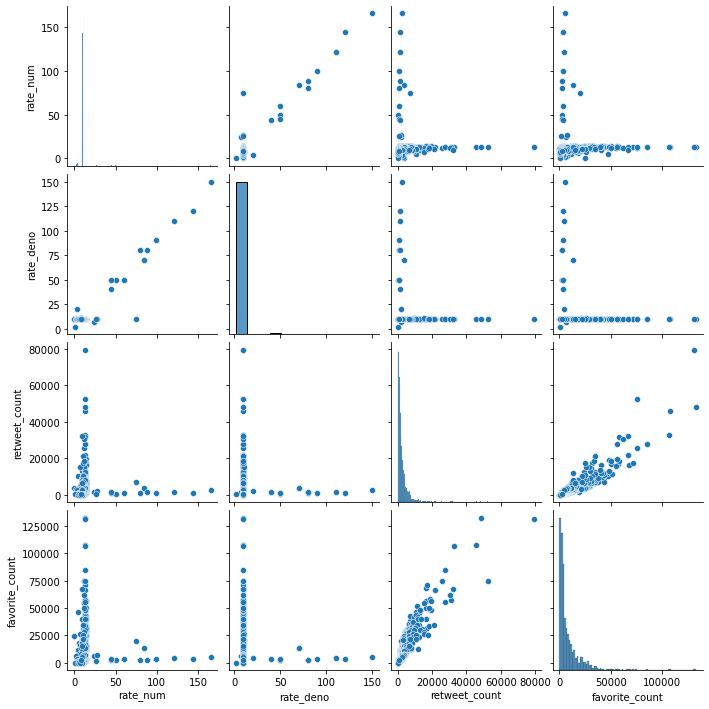

In [63]:
sns.pairplot(df, vars=["rate_num",
                                "rate_deno", 
                                "retweet_count", 
                                "favorite_count", 
                               ]);

**Question 1** Quelle est la race de chien la plus courant dans notre base de données 

In [64]:
df['dog_breed'].value_counts()

golden_retriever        141
labrador_retriever      101
pembroke                 93
chihuahua                86
pug                      60
                       ... 
standard_schnauzer        1
silky_terrier             1
bouvier_des_flandres      1
entlebucher               1
scotch_terrier            1
Name: dog_breed, Length: 113, dtype: int64

****Constat***
nous constatons que la race canin "golden retriever" est le chien le plus courant dans cette base de données (il y a 141 tweets pour golden_retriever)

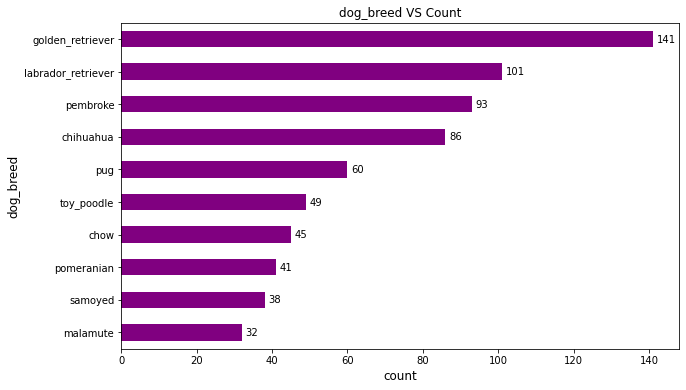

In [65]:
# Plot most common 10 dog_type:
plt.figure(figsize=(10,6))
df['dog_breed'].value_counts()[0:10].sort_values(ascending=True).plot(kind='barh' , color ='purple')

# Set x_label, y_label and title:
plt.xlabel('count',size=12)
plt.ylabel('dog_breed', size=12)
plt.title('dog_breed VS Count' , size=12)

# Set x & y positions to add text over each bar:
x = df['dog_breed'].value_counts()[0:10].sort_values(ascending=True).values
y= np.arange(0,10,1)

# Add text (showing value) over each bar:
for xx, yy in zip(x,y):
    plt.text(xx+1,yy,xx , va='center')

In [66]:
df_dog_breed_mean = df.groupby('dog_breed').mean()

df_dog_breed_mean.head()

,rate_num,rate_deno,year,month,day,rate,retweet_count,favorite_count
dog_breed,,,,,,,,
afghan_hound,8.000000,10.0,2016.500000,6.00,16.000000,8.000000,3602.5000,12191.500000
airedale,9.833333,10.0,2015.583333,8.75,15.916667,9.833333,1393.7500,5280.833333
american_staffordshire_terrier,10.312500,10.0,2016.187500,5.25,15.000000,10.312500,2310.8125,9380.187500
appenzeller,11.000000,10.0,2016.500000,4.50,18.500000,11.000000,1458.0000,7317.500000
australian_terrier,11.500000,10.0,2016.500000,3.50,7.000000,11.500000,3078.5000,11127.500000


In [67]:
df_dog_breed_count = df.groupby('dog_breed').count()
df_dog_breed_count

,tweet_id,text,rate_num,rate_deno,name,doggo,floof,pupper,puppo,year,month,day,rate,retweet_count,favorite_count,jpg_url,conf_list
dog_breed,,,,,,,,,,,,,,,,,
afghan_hound,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
airedale,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
american_staffordshire_terrier,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
appenzeller,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
australian_terrier,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
welsh_springer_spaniel,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
west_highland_white_terrier,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
whippet,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11


**Question 1** : Quelle race de chien a obtenu la note moyenne la plus élevée

In [68]:
top_10 = df.groupby('dog_breed')['rate_num'].mean().sort_values(ascending= False)[0:10]

top_10

dog_breed
clumber                        27.000000
soft-coated_wheaten_terrier    21.357143
west_highland_white_terrier    14.687500
great_pyrenees                 14.666667
chow                           14.311111
labrador_retriever             13.811881
borzoi                         13.600000
siberian_husky                 13.250000
bouvier_des_flandres           13.000000
pomeranian                     12.536585
Name: rate_num, dtype: float64

**Question 2** Quels sont les noms de chien le plus populaire

In [69]:
pop_name = df.name.value_counts()[1:10]

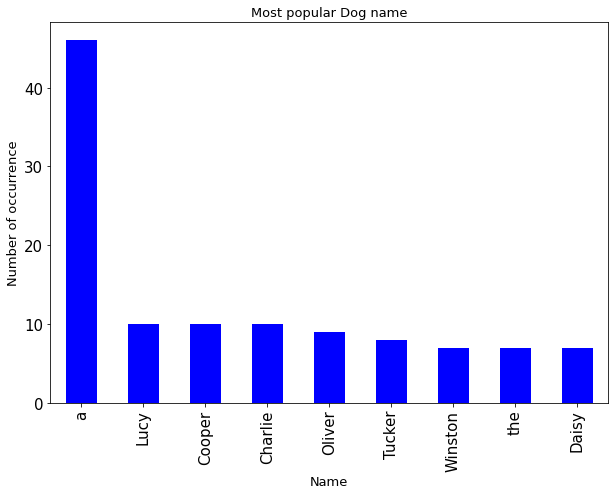

In [70]:
#plot
g_bar = pop_name.plot.bar(color = 'blue', fontsize = 15)

#figure size(width, height)
g_bar.figure.set_size_inches(10, 7);

#Add labels
plt.title('Most popular Dog name', color = 'black', fontsize = '13')
plt.xlabel('Name', color = 'black', fontsize = '13')
plt.ylabel('Number of occurrence', color = 'black', fontsize = '13');

les noms de chien le plus populaire sont ceux avec des noms aléatoires tels que "a" 

**Question 3** : Existe t il une correlation linéraire entre retweet et les favoris_tweet ?

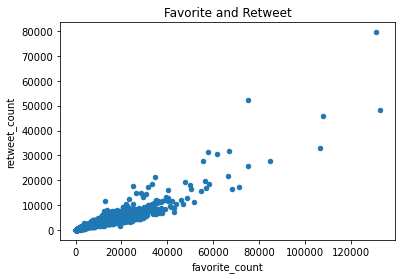

In [71]:
# Correlation between profit and budget
df.plot(x='favorite_count', y='retweet_count', kind='scatter', title = 'Favorite and Retweet');

In [72]:
df['favorite_count'].corr(df['retweet_count'])

0.905749736466604

Oui au regard du nuage de points ci-dessus nous constatons qu'il existe bien une corrélation positive entre les favoris_tweet et les retweet.

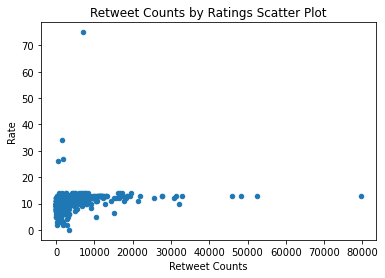

In [76]:
df.plot(x='retweet_count', y='rate', kind='scatter')
plt.xlabel('Retweet Counts')
plt.ylabel('Rate')
plt.title('Retweet Counts by Ratings Scatter Plot')

fig = plt.gcf()
fig.savefig('output3.png',bbox_inches='tight');

# Conclusion

Nous pouvons dire que de nombreux autres paramètres peuvent être analysés de cet ensemble de données ceci pour différentes informations souhaitées. 
Aussi, un bon gestionnaire de données doit être capable de rassembler des informations provenant de diverses sources de données, de résoudre des problèmes de régularités de donnée, de nettoyage et de qualité des données. 

Ce projet est le premier projet passionnant sur lequel j'ai travaillé jusqu'à présent. 
